# Stellargraph example: Personalised Propagation of Neural Predictions (PPNP) and Approximate PPNP (APPNP) on the CORA citation dataset

Import NetworkX and stellar:

In [22]:
import networkx as nx
import pandas as pd
import os
import keras

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer.ppnp import PPNP
from stellargraph.layer.appnp import APPNP

from keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

### Loading the CORA network

**Downloading the CORA dataset:**
    
The dataset used in this demo can be downloaded from [here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz).

The following is the description of the dataset:
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes.
> The citation network consists of 5429 links. Each publication in the dataset is described by a
> 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.
> The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

Download and unzip the cora.tgz file to a location on your computer and set the `data_dir` variable to
point to the location of the dataset (the directory containing "cora.cites" and "cora.content").

In [8]:
data_dir = os.path.expanduser("~/data/cora")

Load the graph from edgelist (in the order `cited-paper` <- `citing-paper`)

In [9]:
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"

In [10]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")

In [11]:
nx.set_node_attributes(Gnx, "paper", "label")

Load the features and subject for the nodes

In [12]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)

We aim to train a graph-ML model that will predict the "subject" attribute on the nodes. These subjects are one of 7 categories:

In [13]:
set(node_data["subject"])

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn again to do this.

Here we're taking 140 node labels for training, 500 for validation, and the rest for testing.

In [14]:
train_data, test_data = model_selection.train_test_split(
    node_data, train_size=140, test_size=None, stratify=node_data['subject']
)
val_data, test_data = model_selection.train_test_split(
    test_data, train_size=500, test_size=None, stratify=test_data['subject']
)

Note using stratified sampling gives the following counts:

In [15]:
from collections import Counter
Counter(train_data['subject'])

Counter({'Neural_Networks': 42,
         'Rule_Learning': 9,
         'Case_Based': 16,
         'Genetic_Algorithms': 22,
         'Probabilistic_Methods': 22,
         'Theory': 18,
         'Reinforcement_Learning': 11})

The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [16]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[["subject"]].to_dict('records'))
val_targets = target_encoding.transform(val_data[["subject"]].to_dict('records'))
test_targets = target_encoding.transform(test_data[["subject"]].to_dict('records'))

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

In [17]:
node_features = node_data[feature_names]

## Creating the PPNP model in Keras

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

In [18]:
G = sg.StellarGraph(Gnx, node_features=node_features)

In [19]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]



To feed data from the graph to the Keras model we need a generator. Since PPNP is a full-batch model, we use the `FullBatchNodeGenerator` class to feed node features and the normalized graph Laplacian matrix to the model.

Specifying the `method='gcn'` argument to the `FullBatchNodeGenerator` will pre-process the adjacency matrix and supply the normalized graph Laplacian matrix to the model.

In [30]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


For training we map only the training nodes returned from our splitter and the target values.

In [31]:
train_gen = generator.flow(train_data.index, train_targets)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each full fully connected layer in the model. In this example we use three fully connected layers with 64,64, and 7 hidden node features at each layer. 
 * `activations` is a list of activations applied to each layer's output
 * `dropout=0.5` specifies a 50% dropout at each layer. 
 
 #### Note that the size of the final fully connected layer must be equal to the number of classes you are trying to predict.


We create a PPNP model as follows:

In [43]:
ppnp = PPNP([64, 64, 7], ['relu', 'relu', 'relu'], 
             generator, transport_probability=0.1, 
              dropout=0.5, kernel_regularizer=keras.regularizers.l2(0.001))

x_inp, x_out = ppnp.node_model()

model = keras.models.Model(inputs=x_inp, outputs=x_out)
model.compile(loss='categorical_crossentropy', metrics=['acc'],
                  optimizer=keras.optimizers.Adam(lr=0.01))


### Training the model

Now let's create the actual Keras model with the input tensors `x_inp` and output tensors being the predictions `predictions` from the final dense layer

In [44]:
model = Model(inputs=x_inp, outputs=x_out)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the validation set (we need to create another generator over the validation data for this)

In [45]:
val_gen = generator.flow(val_data.index, val_targets)

Create callbacks for early stopping (if validation accuracy stops improving) and best model checkpoint saving:

In [46]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(monitor="val_acc", patience=50)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5",
    monitor="val_acc",
    save_best_only=True,
    save_weights_only=True,
)

Train the model

In [47]:
history = model.fit_generator(
    train_gen,
    epochs=80,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/80
 - 1s - loss: 2.1519 - acc: 0.1286 - val_loss: 2.0960 - val_acc: 0.3520
Epoch 2/80
 - 0s - loss: 2.0943 - acc: 0.2571 - val_loss: 2.0401 - val_acc: 0.3500
Epoch 3/80
 - 0s - loss: 2.0338 - acc: 0.3286 - val_loss: 1.9791 - val_acc: 0.3060
Epoch 4/80
 - 0s - loss: 1.9415 - acc: 0.3357 - val_loss: 1.9169 - val_acc: 0.3020
Epoch 5/80
 - 0s - loss: 1.9144 - acc: 0.3214 - val_loss: 1.8584 - val_acc: 0.3020
Epoch 6/80
 - 0s - loss: 1.8717 - acc: 0.3429 - val_loss: 1.8049 - val_acc: 0.3260
Epoch 7/80
 - 0s - loss: 1.8452 - acc: 0.3286 - val_loss: 1.7406 - val_acc: 0.4000
Epoch 8/80
 - 0s - loss: 1.8435 - acc: 0.3500 - val_loss: 1.6659 - val_acc: 0.4640
Epoch 9/80
 - 0s - loss: 1.7051 - acc: 0.4214 - val_loss: 1.5980 - val_acc: 0.5400
Epoch 10/80
 - 0s - loss: 1.6535 - acc: 0.4286 - val_loss: 1.5395 - val_acc: 0.5720
Epoch 11/80
 - 0s - loss: 1.5633 - acc: 0.5000 - val_loss: 1.4843 - val_acc: 0.5860
Epoch 12/80
 - 0s - loss: 1.5498 - acc: 0.4643 - val_loss: 1.4277 - val_acc: 0.6400
E

Plot the training history:

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

def plot_history(history):
    metrics = sorted(set([remove_prefix(m, "val_") for m in list(history.history.keys())]))
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='best')
        plt.show()

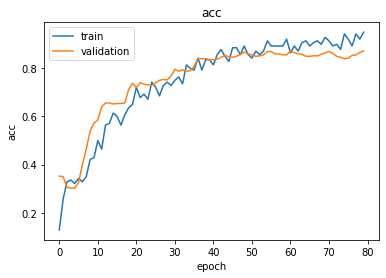

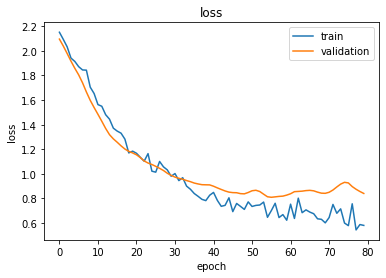

In [49]:
plot_history(history)

Reload the saved weights of the best model found during the training (according to validation accuracy)

In [50]:
model.load_weights("logs/best_model.h5")

Evaluate the best model on the test set

In [51]:
test_gen = generator.flow(test_data.index, test_targets)

In [52]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.8292
	acc: 0.8486


## Using the Approximate PPNP Model

Lets repeat the training and testing steps with the APPNP model using the same dataset. The downside of the PPNP is that you have to invert the adjacency matrix - which is time inneficient for large graphs - and store that invert matrix - which is space innefficient! The approximate model avoids this issue by using a clever mathematical trick.

In [56]:
appnp = APPNP([64, 64, 7], ['relu', 'relu', 'relu'], 
             generator, transport_probability=0.1, 
              dropout=0.5, kernel_regularizer=keras.regularizers.l2(0.001))

x_inp, x_out = appnp.node_model()

model = keras.models.Model(inputs=x_inp, outputs=x_out)
model.compile(loss='categorical_crossentropy', metrics=['acc'],
                  optimizer=keras.optimizers.Adam(lr=0.01))

history = model.fit_generator(
    train_gen,
    epochs=120,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/120
 - 1s - loss: 2.1426 - acc: 0.1571 - val_loss: 2.0705 - val_acc: 0.3040
Epoch 2/120
 - 0s - loss: 2.0689 - acc: 0.2857 - val_loss: 2.0102 - val_acc: 0.3040
Epoch 3/120
 - 0s - loss: 2.0050 - acc: 0.3071 - val_loss: 1.9445 - val_acc: 0.3260
Epoch 4/120
 - 0s - loss: 2.0782 - acc: 0.2571 - val_loss: 1.9037 - val_acc: 0.4620
Epoch 5/120
 - 0s - loss: 1.9717 - acc: 0.3000 - val_loss: 1.8636 - val_acc: 0.4880
Epoch 6/120
 - 0s - loss: 1.9264 - acc: 0.3214 - val_loss: 1.8226 - val_acc: 0.5080
Epoch 7/120
 - 0s - loss: 1.8372 - acc: 0.4143 - val_loss: 1.7673 - val_acc: 0.5360
Epoch 8/120
 - 0s - loss: 1.8418 - acc: 0.3571 - val_loss: 1.7031 - val_acc: 0.5580
Epoch 9/120
 - 0s - loss: 1.8350 - acc: 0.4286 - val_loss: 1.6307 - val_acc: 0.5720
Epoch 10/120
 - 0s - loss: 1.7053 - acc: 0.4857 - val_loss: 1.5532 - val_acc: 0.6100
Epoch 11/120
 - 0s - loss: 1.6724 - acc: 0.5286 - val_loss: 1.4702 - val_acc: 0.6420
Epoch 12/120
 - 0s - loss: 1.6221 - acc: 0.5571 - val_loss: 1.3900 - val_a

Epoch 98/120
 - 0s - loss: 0.7414 - acc: 0.9286 - val_loss: 0.9366 - val_acc: 0.8460
Epoch 99/120
 - 0s - loss: 0.7939 - acc: 0.9071 - val_loss: 0.9458 - val_acc: 0.8400
Epoch 100/120
 - 0s - loss: 0.7149 - acc: 0.9357 - val_loss: 0.9506 - val_acc: 0.8380
Epoch 101/120
 - 0s - loss: 0.7030 - acc: 0.9143 - val_loss: 0.9526 - val_acc: 0.8360
Epoch 102/120
 - 0s - loss: 0.7865 - acc: 0.9071 - val_loss: 0.9458 - val_acc: 0.8340
Epoch 103/120
 - 0s - loss: 0.7675 - acc: 0.8929 - val_loss: 0.9321 - val_acc: 0.8420
Epoch 104/120
 - 0s - loss: 0.8297 - acc: 0.9071 - val_loss: 0.9248 - val_acc: 0.8460
Epoch 105/120
 - 0s - loss: 0.8678 - acc: 0.9000 - val_loss: 0.9269 - val_acc: 0.8440
Epoch 106/120
 - 0s - loss: 0.8908 - acc: 0.8500 - val_loss: 0.9291 - val_acc: 0.8420
Epoch 107/120
 - 0s - loss: 0.7775 - acc: 0.9000 - val_loss: 0.9373 - val_acc: 0.8340
Epoch 108/120
 - 0s - loss: 0.7133 - acc: 0.9214 - val_loss: 0.9466 - val_acc: 0.8300
Epoch 109/120
 - 0s - loss: 0.7755 - acc: 0.8929 - val_l

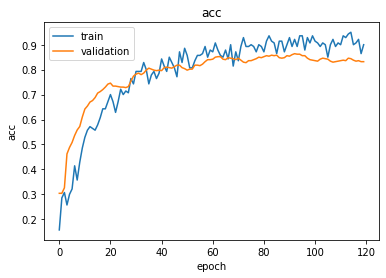

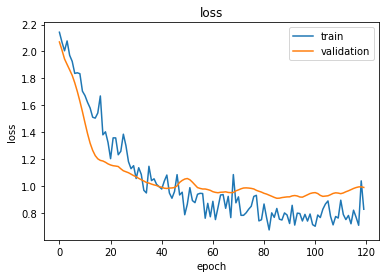

In [57]:
plot_history(history)

### Making predictions with the model

Now let's get the predictions for all nodes.

In [58]:
all_nodes = node_data.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict_generator(all_gen)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specifcation to turn these values back to the original categories.

Note that for full-batch methods the batch size is 1 and the predictions have shape $(1, N_{nodes}, N_{classes})$ so we we remove the batch dimension to obtain predictions of shape $(N_{nodes}, N_{classes})$ using the NumPy `squeeze` method.

In [59]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

Let's have a look at a few predictions after training the model:

In [60]:
results = pd.DataFrame(node_predictions, index=all_nodes).idxmax(axis=1)
df = pd.DataFrame({"Predicted": results, "True": node_data['subject']})
df.head(20)

,Predicted,True
31336,subject=Neural_Networks,Neural_Networks
1061127,subject=Rule_Learning,Rule_Learning
1106406,subject=Reinforcement_Learning,Reinforcement_Learning
13195,subject=Reinforcement_Learning,Reinforcement_Learning
37879,subject=Probabilistic_Methods,Probabilistic_Methods
1126012,subject=Probabilistic_Methods,Probabilistic_Methods
1107140,subject=Theory,Theory
1102850,subject=Neural_Networks,Neural_Networks
31349,subject=Neural_Networks,Neural_Networks
1106418,subject=Theory,Theory
